In [8]:
import pandas as pd
import scanpy as sc
import anndata as ad
import squidpy as sq
import scipy.sparse as sp
from scipy.cluster import hierarchy as sch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [113]:
adata = ad.read_h5ad("adata.h5ad")

In [128]:
# preprocessing and clustering function
def BasicScanpyPreprocessing(adata, resolution=None, n_comps=50):
#     sc.pp.normalize_total(adata, inplace=True) # Normalize counts per cell
#     sc.pp.log1p(adata) # Logarithmize the data matrix
#     sc.pp.scale(adata) # we dont need to sscale the data
    sc.pp.pca(adata, n_comps=n_comps)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, key_added="Leiden", resolution=resolution)
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    return adata

In [115]:
(adata.obs['Cell_class_2']).unique()

['Endothelial', 'Hybrid', 'Astrocytes', 'Inhibitory', 'Excitatory', 'OD', 'Microglia', 'Ependymal']
Categories (8, object): ['Astrocytes', 'Endothelial', 'Ependymal', 'Excitatory', 'Hybrid', 'Inhibitory', 'Microglia', 'OD']

In [116]:
adata

AnnData object with n_obs × n_vars = 28317 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts', 'Leiden', 'n_genes_by_counts', 'total_counts', 'Cell_class_2'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Leiden', 'Leiden_colors', 'dendrogram_Leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [129]:
# extracting ['Inhibitory','Excitatory','Hybrid'] to recluster them for further analysis
IE=['Inhibitory','Excitatory','Hybrid']
IE_subset=adata[adata.obs['Cell_class_2'].isin(IE)]
(IE_subset.obs['Cell_class_2']).unique()
# deleting old clusters resuult like dendrogram_Leiden
del IE_subset.uns['dendrogram_Leiden']

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarni

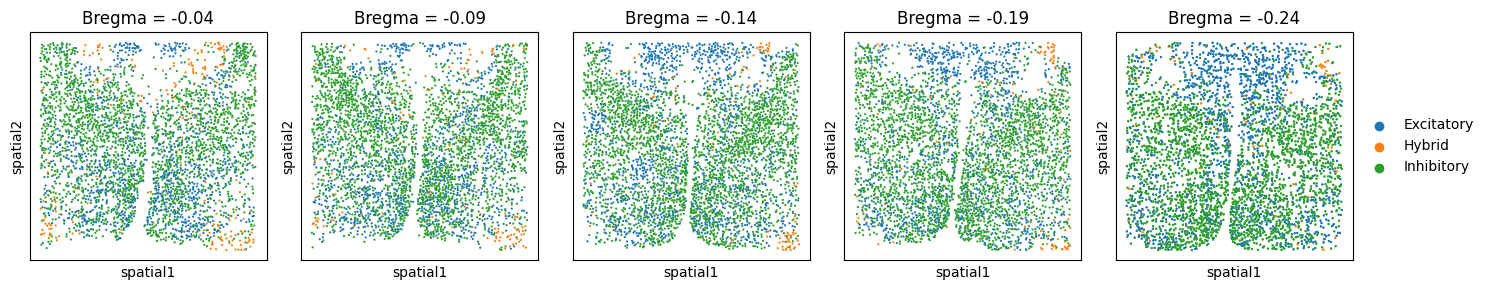

In [118]:
# ploting identified clusters of the paper
bregma_sections = [-0.04, -0.09, -0.14, -0.19, -0.24]

# Create subplots (one column per Bregma section)
fig, axs = plt.subplots(1, len(bregma_sections), figsize=(15, 3))

# Plot each Bregma section
for i, bregma in enumerate(bregma_sections):
    # Filter data for the current Bregma section
    adata_section = IE_subset[IE_subset.obs['Bregma'] == bregma]
    
    # Plot embedding
    sc.pl.embedding(adata_section, basis="spatial", color="Cell_class_2", ax=axs[i], show=False, legend_loc=None,size=10)
    
    # Set title for each subplot
    axs[i].set_title(f'Bregma = {bregma}')
    
sc.pl.embedding(IE_subset[IE_subset.obs['Bregma']==-0.24], basis="spatial", color="Cell_class_2", ax=axs[4], show=False,size=10)
axs[4].set_title('Bregma = -0.24')
# Adjust layout
plt.tight_layout()
plt.show()

In [133]:
# re-clustering 
BasicScanpyPreprocessing(IE_subset, resolution=0.65, n_comps=50)

AnnData object with n_obs × n_vars = 19207 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts', 'Leiden', 'n_genes_by_counts', 'total_counts', 'Cell_class_2'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Leiden', 'Leiden_colors', 'dendrogram_Leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'spatial_neighbors', 'Leiden_nhood_enrichment'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

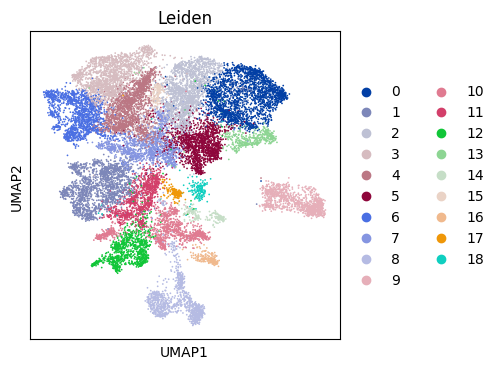

In [134]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(IE_subset, color=["Leiden"], wspace=0.4)

  0%|          | 0/1000 [00:00<?, ?/s]

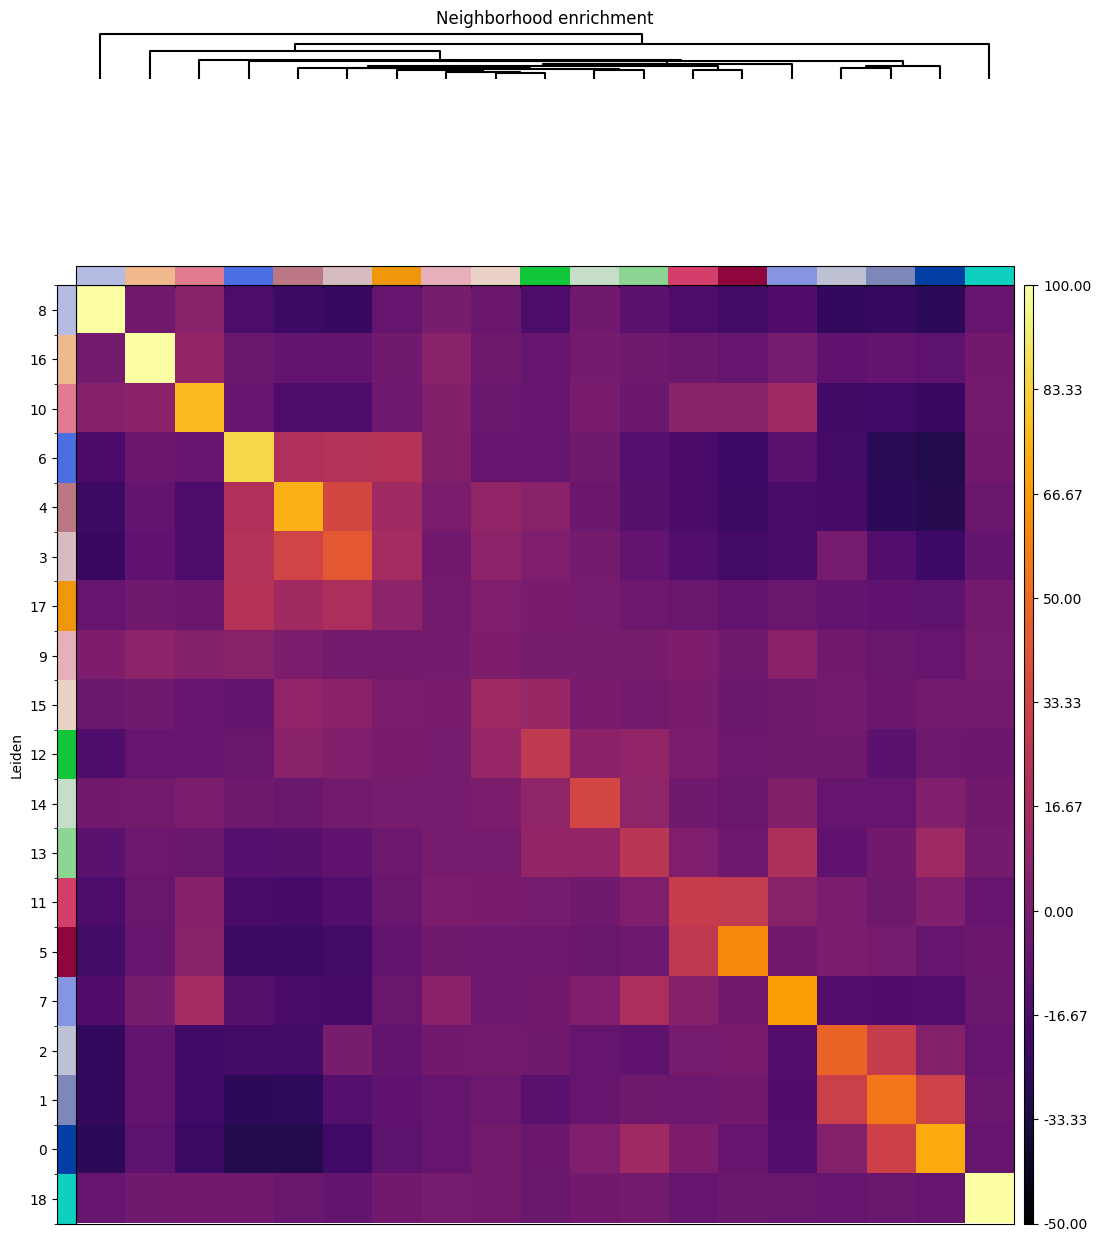

In [153]:
# Neighborhood Enrichment analysis
sq.gr.spatial_neighbors(IE_subset, coord_type="generic", spatial_key="spatial")
sq.gr.nhood_enrichment(IE_subset, cluster_key="Leiden")
#  hierarchically clustered heatmap which shows clusters of enriched neighborhoods in our tissue
sq.pl.nhood_enrichment(
    IE_subset, cluster_key="Leiden", method="single", cmap="inferno", vmin=-50, vmax=100
)

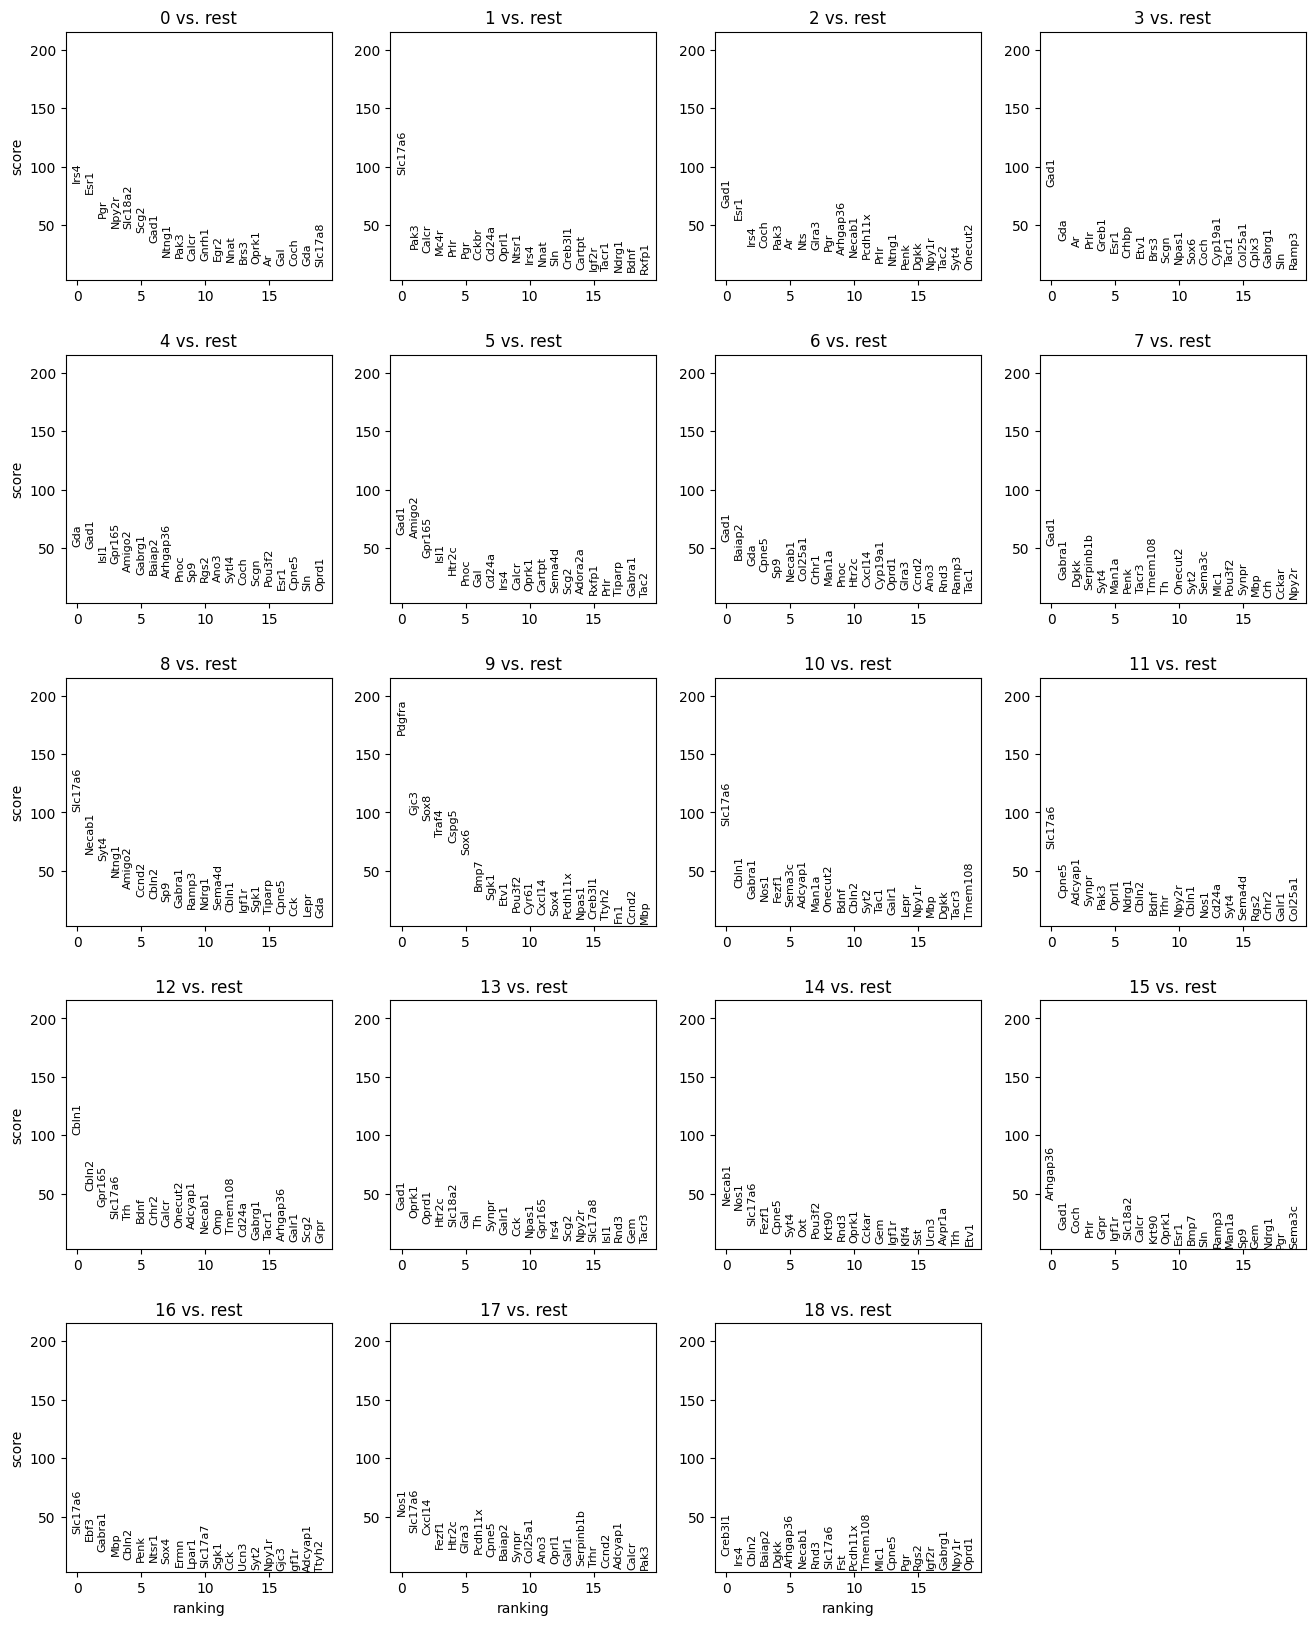

In [150]:
sc.tl.rank_genes_groups(IE_subset, groupby="Leiden")
sc.pl.rank_genes_groups(IE_subset, groupby="Leiden")

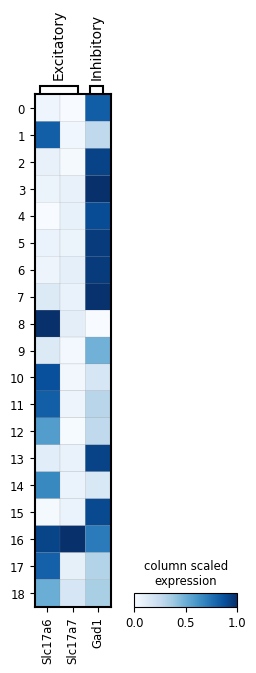

In [151]:
marker_genes_dict = {
    'Excitatory': ['Slc17a6','Slc17a7'],
    'Inhibitory': ['Gad1']
}
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.matrixplot(IE_subset, marker_genes_dict, 'Leiden', cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

## based on the heatmap clusters 0,2,3,4,5,6,7,13,15 are inhibitory while clusters 1,8,10,11,12,14,17,18 and cluster 16 is hybrid



In [185]:
# asigning the excitatory and inhibatory to its clusters
# Example of annotating manually based on marker genes
cluster_to_cell_type = {
    '0': 'I1',
    '2': 'I2',
    '3': 'I3',
    '4': 'I4',
    '5': 'I5',
    '6': 'I6',
    '7': 'I7',
    '9': 'I8',#
    '13': 'I9',
    '15': 'I10',
    '1': 'E1',
    '8': 'E2',#1
    '10': 'E3',
    '11': 'E4',
    '12': 'E5',#
    '14': 'E6',
    '17': 'E7',#
    '18': 'E8',#1
    '16': 'H'#1
}

# Add this information to the AnnData object
IE_subset.obs['N_cluster_Id_2'] = IE_subset.obs['Leiden'].map(cluster_to_cell_type)


In [186]:
(IE_subset.obs['N_cluster_Id_2']).unique()

['I7', 'I6', 'E4', 'I8', 'H', ..., 'E7', 'E6', 'E2', 'I10', 'E8']
Length: 19
Categories (19, object): ['I1', 'E1', 'I2', 'I3', ..., 'I10', 'H', 'E7', 'E8']

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


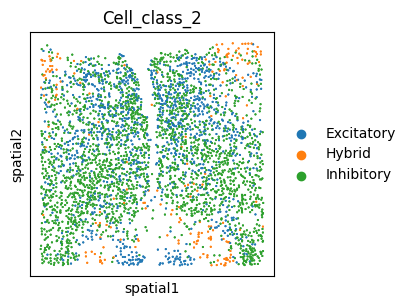

In [159]:
sq.pl.spatial_scatter(
    IE_subset[IE_subset.obs.Bregma == -0.04], shape=None, color="Cell_class_2", size=1
)

/opt/conda/lib/python3.10/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data
/opt/conda/lib/python3.10/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


/opt/conda/lib/python3.10/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data
/opt/conda/lib/python3.10/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


/opt/conda/lib/python3.10/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


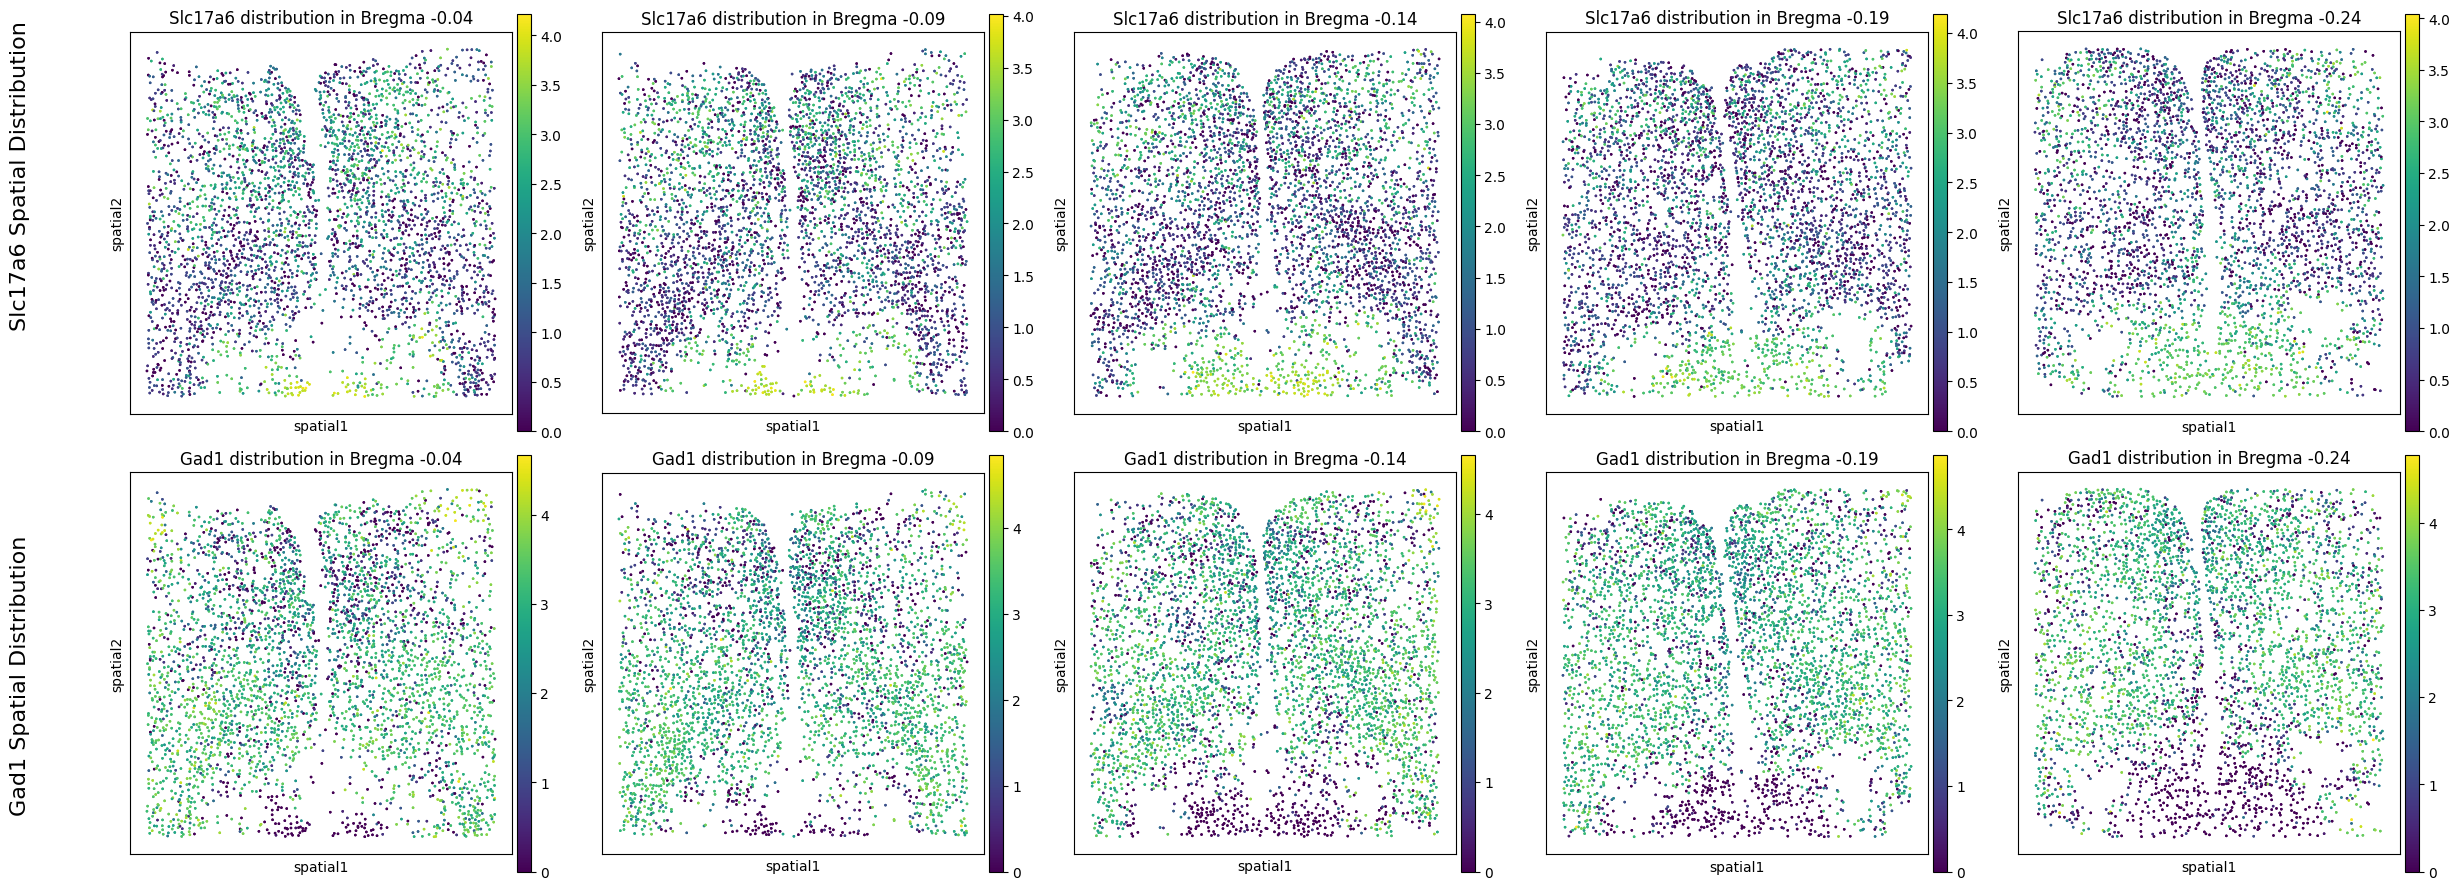

In [179]:
bregma_sections = [-0.04, -0.09, -0.14, -0.19, -0.24]

# Create a figure with 2 rows and 5 columns (5 Bregma sections for each gene)
fig, axes = plt.subplots(2, 5, figsize=(25, 10)) 

# Loop over Bregma sections 
for idx, bregma in enumerate(bregma_sections):
    # Subset the AnnData object for each Bregma section
    adata_slice = IE_subset[IE_subset.obs["Bregma"].copy() == bregma]
    sq.gr.spatial_neighbors(adata_slice, coord_type="generic")
    sq.gr.spatial_autocorr(adata_slice, mode="moran")
    adata_slice.uns["moranI"].head()
    
    # Plot Slc17a6 in the first row
    sq.pl.spatial_scatter(adata_slice, shape=None, color="Slc17a6", ax=axes[0, idx], size=3, title=f"Slc17a6 distribution in Bregma {bregma}")

    # Plot Gad1 in the second row
    sq.pl.spatial_scatter(adata_slice, shape=None, color="Gad1", ax=axes[1, idx], size=3, title=f"Gad1 distribution in Bregma {bregma}")

fig.text(0.02, 0.75, 'Slc17a6 Spatial Distribution', va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.02, 0.25, 'Gad1 Spatial Distribution', va='center', ha='center', rotation='vertical', fontsize=16)

# Adjust the spacing between plots
plt.tight_layout(rect=[0.05, 0.03, 1, 0.93])  
plt.show()


In [232]:
# fucntion to visualize separate clsuters acroos each tissue section 
def plotClusters(adata, groups1, groups2,add_tittle=False):
    bregma_sections = [-0.04, -0.09, -0.14, -0.19, -0.24]

    fig, axs = plt.subplots(2, len(bregma_sections), figsize=(20, 6))
    
    for idx, bregma in enumerate(bregma_sections):
        bregma_section = adata[adata.obs['Bregma'] == bregma]
        # Plot groups1
        sc.pl.embedding(bregma_section, basis="spatial", color="N_cluster_Id_2", groups=groups1, ax=axs[0, idx], size=30, show=False, legend_loc=None)
        axs[0, idx].set_title(f'Bregma {bregma}')
            
        # Plot groups2
        sc.pl.embedding(bregma_section, basis="spatial", color="N_cluster_Id_2", groups=groups2, ax=axs[1, idx], size=30, show=False, legend_loc=None)
        axs[1, idx].set_title(f'Bregma {bregma}')

    sc.pl.embedding(adata[adata.obs['Bregma'] == -0.24], basis="spatial", color="N_cluster_Id_2", groups=groups1, ax=axs[0, 4], size=30, show=False)
    axs[0, idx].set_title(f'Bregma {bregma}')
            
    # Plot groups2
    sc.pl.embedding(adata[adata.obs['Bregma'] == -0.24], basis="spatial", color="N_cluster_Id_2", groups=groups2, ax=axs[1, 4], size=30, show=False)
    axs[1, idx].set_title(f'Bregma {bregma}')

    if add_tittle is True: # adding tittle for the dispersed and localized clusters
        fig.text(0.02, 0.75, 'dispersed clusters', va='center', ha='center', rotation='vertical', fontsize=16)
        fig.text(0.02, 0.25, 'localized clusters', va='center', ha='center', rotation='vertical', fontsize=16)

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.93])
    plt.show()


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarni

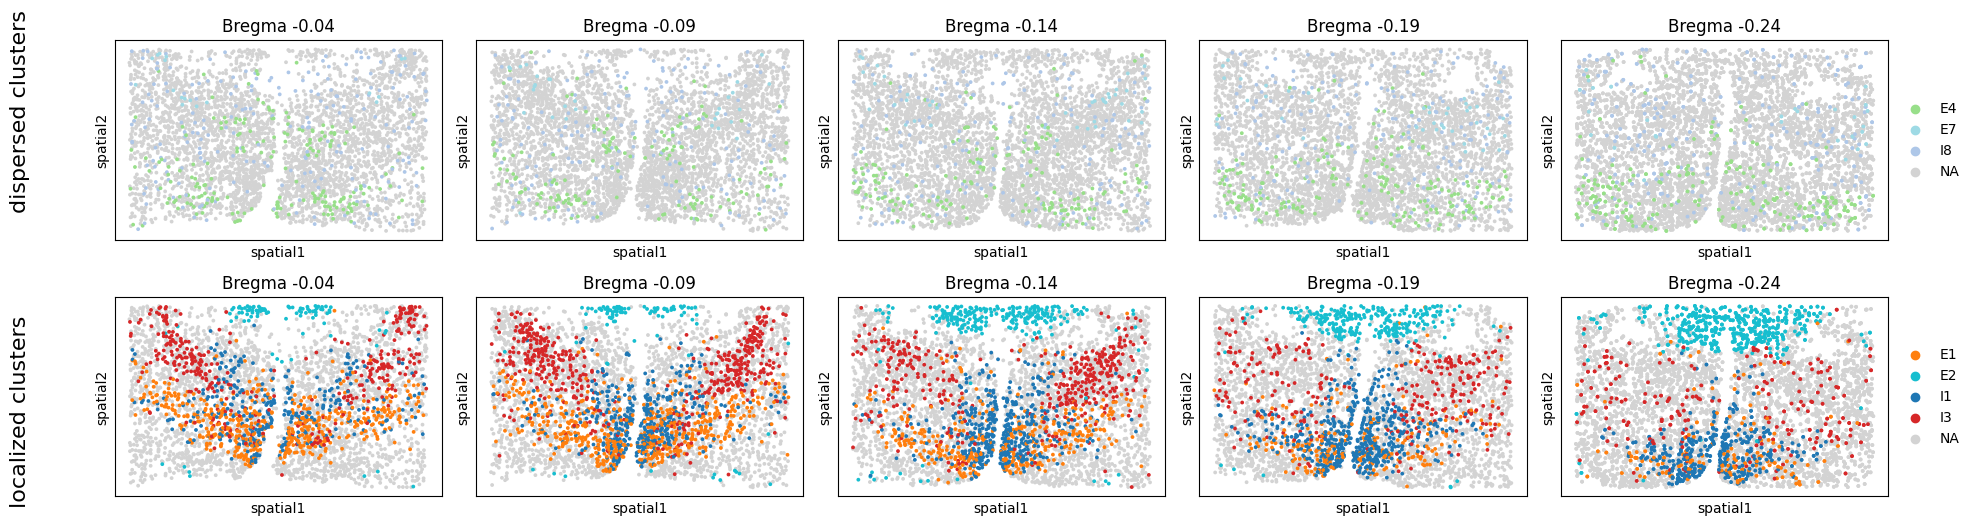

In [233]:
plotClusters(IE_subset, groups1=['I8','E7', 'E4'], groups2=['I1', 'E1','I3','E2'], add_tittle=True)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarni

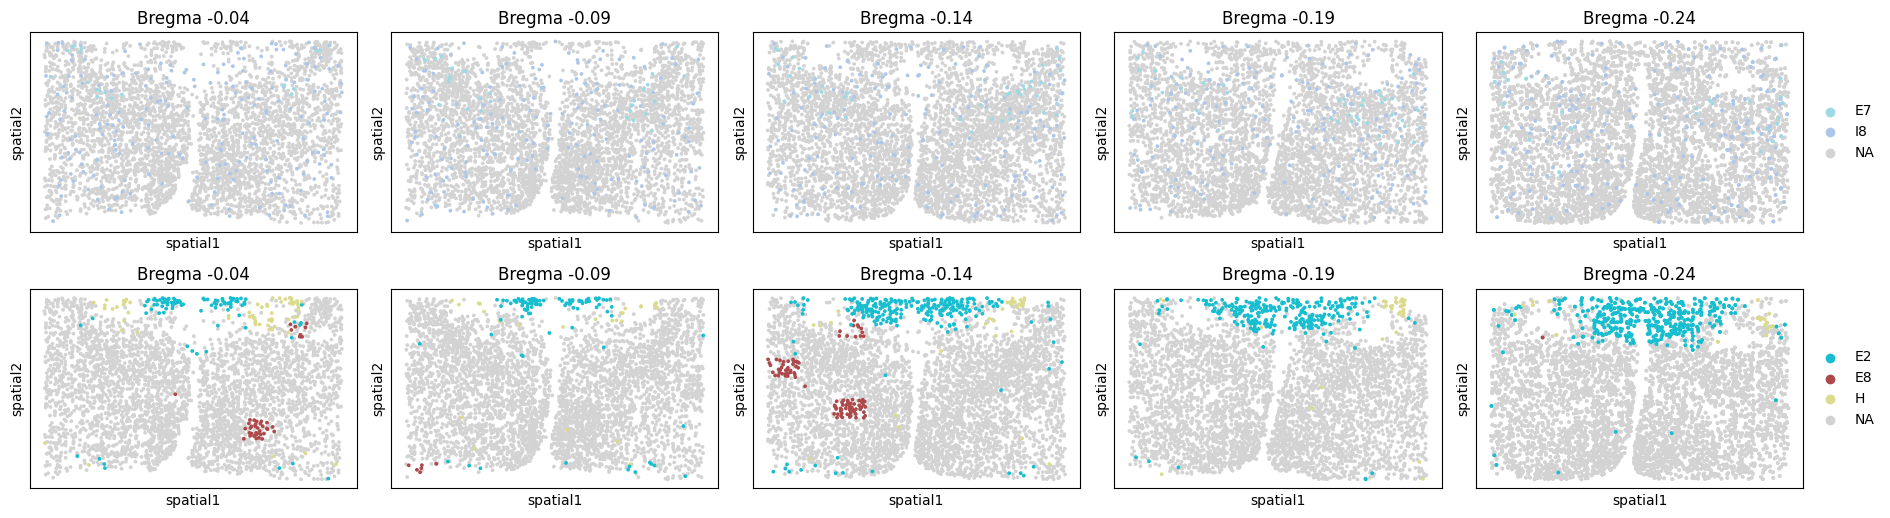

In [234]:
plotClusters(IE_subset, groups1=['I8','E7'], groups2=['E2', 'E8','H'])

In [ ]:
IE_subset.write('IE_subset.csv')